# Stacking rankers demo

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from rankers.Stacker import Stacker
from rankers.Ranker import Ranker
import numpy as np
import pandas as pd
from Evaluations import get_evaluation_plots


In [2]:
#10 weeks in total for training, validation is done on last 5 weeks
nr_training_weeks = 10
nr_validation_weeks = 5

In [3]:
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False, nr_training_weeks=nr_training_weeks)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1


In [4]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [5]:
test_X = test#[columns_to_use]

In [6]:
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [7]:
adaboost_ranker = Ranker(AdaBoostClassifier())

In [8]:
gnb_ranker = Ranker(GaussianNB())

### Metamodel (using AdaBoost ranker as metamodel)

In [9]:
stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], Ranker(AdaBoostClassifier()), use_groups=[True, False, False])

In [10]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

computing validation predictions for each of the base rankers...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848005
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.145441
[LightGBM] [Debug] init for col-wise cost 0.107019 seconds, init for row-wise cost 0.380686 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 6432764, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.861097
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.149076
[LightGBM] [Debug] init for col-wise cost 0.093338 seco

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.119482
[LightGBM] [Debug] init for col-wise cost 0.000056 seconds, init for row-wise cost 0.328999 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 5124830, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13


In [11]:
test['ranker_meta_model'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   8.   1. ]
 [ 2.   9.  13. ]
 [ 7.  10.   8. ]
 ...
 [ 7.   6.  10. ]
 [ 7.   2.   4. ]
 [12.5 12.  11. ]]


### Metamodel using AdaBoost Regressor as metamodel

In [12]:
stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], AdaBoostRegressor(), use_groups=[True, False, False])

In [13]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

computing validation predictions for each of the base rankers...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848005
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.145441
[LightGBM] [Debug] init for col-wise cost 0.089326 seconds, init for row-wise cost 0.382621 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 6432764, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.861097
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.149076
[LightGBM] [Debug] init for col-wise cost 0.080264 seco

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.119482
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.395159 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 5124830, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13


In [14]:
test['regressor_meta_model'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   8.   1. ]
 [ 2.   9.  13. ]
 [ 7.  10.   8. ]
 ...
 [ 7.   6.  10. ]
 [ 7.   2.   4. ]
 [12.5 12.  11. ]]


### Weighted rank aggregation (no metamodel)

In [15]:
#removing last few weeks from train (used for validation with metamodel stacker)
#train = train[(train.week >= train.week.min()+nr_validation_weeks)]

In [16]:
#stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], None, use_groups=[True, False, False])

In [17]:
#stacker = stacker.fit(train, columns_to_use, None)

In [18]:
#predicting with rankers, unweighted (all rankers considered equally)
test['unweighted'] = stacker.predict(test_X, columns_to_use, weighting=None)

Predicting with None weighting


In [19]:
test['MRR_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MRR")

Predicting with MRR weighting


In [20]:
test['MAPk_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MAPk")

Predicting with MAPk weighting


In [21]:
test['Pk_weighted'] = stacker.predict(test_X, columns_to_use, weighting="Pk")

Predicting with Pk weighting


Base rankers already fit to data by stacker, so can just call predict to get their predictions

In [22]:
test['lgbm'] = lgbm_ranker.predict(test_X[columns_to_use])

In [23]:
test['adaboost'] = adaboost_ranker.predict(test_X[columns_to_use])

In [24]:
test['naive_bayes'] = gnb_ranker.predict(test_X[columns_to_use])

In [25]:
pred_cols = ['unweighted', 'MRR_weighted', 'MAPk_weighted', 'lgbm', 'adaboost', 'naive_bayes', 'ranker_meta_model', 'regressor_meta_model']

In [26]:
stacker.ranker_weights

{'MRR': [0.9347483118683491, 0.6897846467682945, 0.9003159348981736],
 'MAPk': [0.8737509332620338, 0.502596190746297, 0.8288666352635037],
 'Pk': [0.0, 0.0, 0.0]}

Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011028280432373943
MAP@12 (only purchasing customers): 0.021933463103920338

MRR (all customers):                0.00210979268079226
MRR (only purchasing customers):    0.04196035837575908



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.0011061457203811861
MAP@12 (only purchasing customers): 0.021999446327388664

MRR (all customers):                0.002113270002105846
MRR (only purchasing customers):    0.04202951666312737



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.0011132908008257359
MAP@12 (only purchasing customers): 0.022141550401787273

MRR (all customers):                0.002122842095035577
MRR (only purchasing customers):    0.042219890083887726



Evaluation for lgbm
####################

MAP@12 (all customers):             0.0011825299209288645
MAP@12 (only purchasing customers): 0.02351860432732203

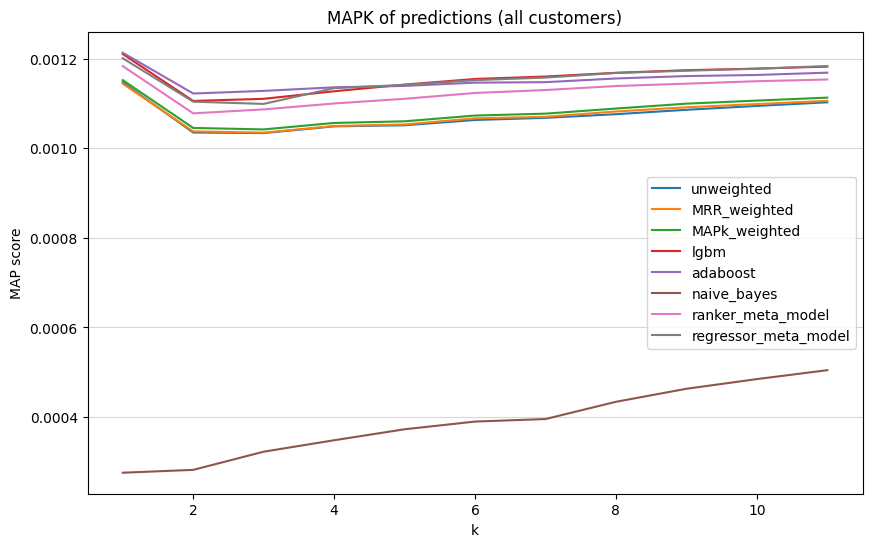

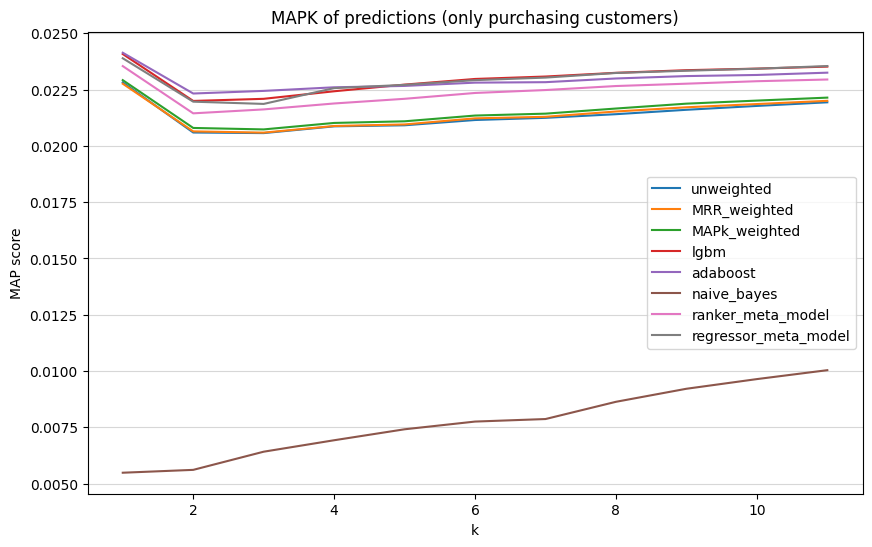

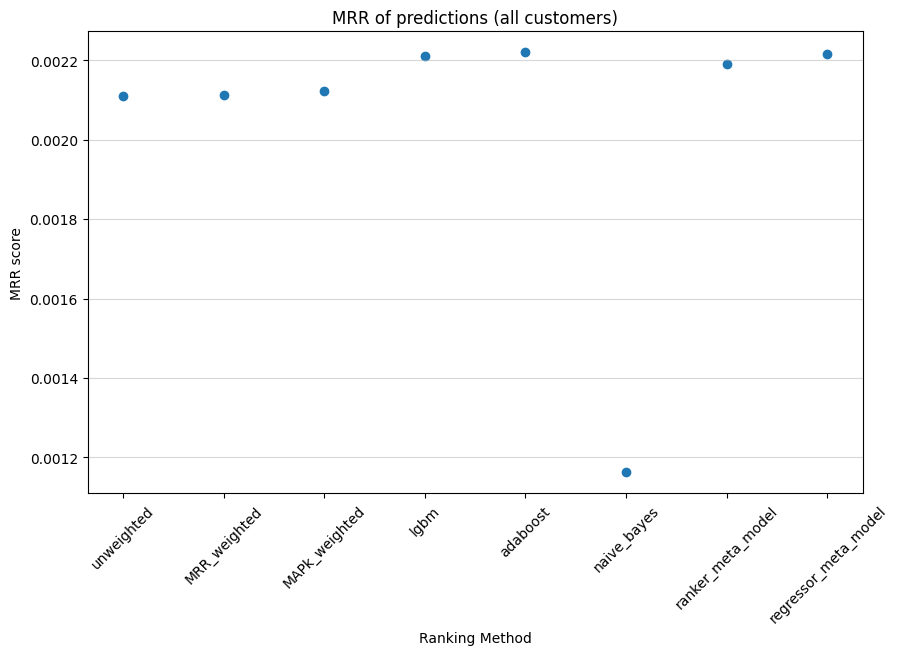

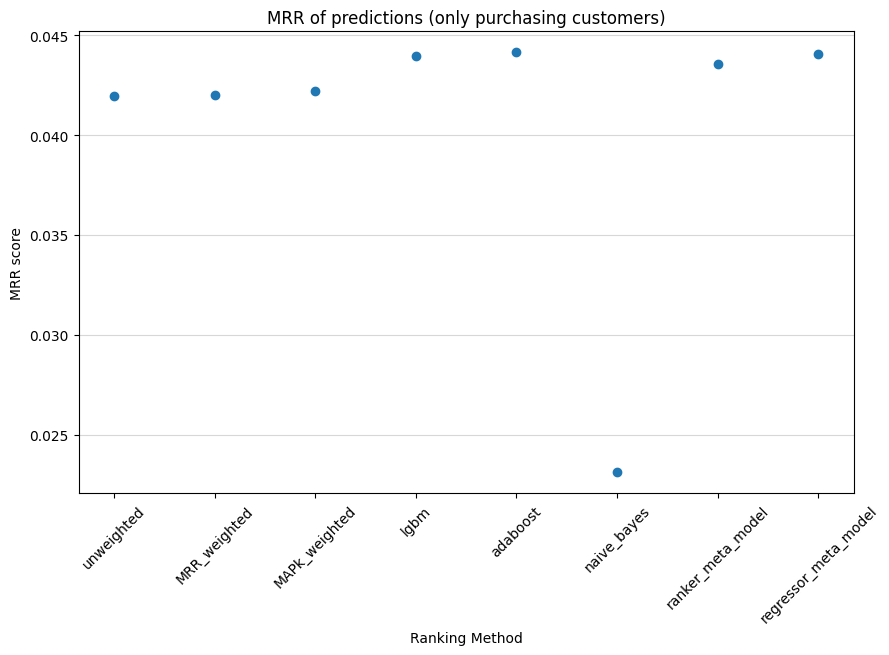

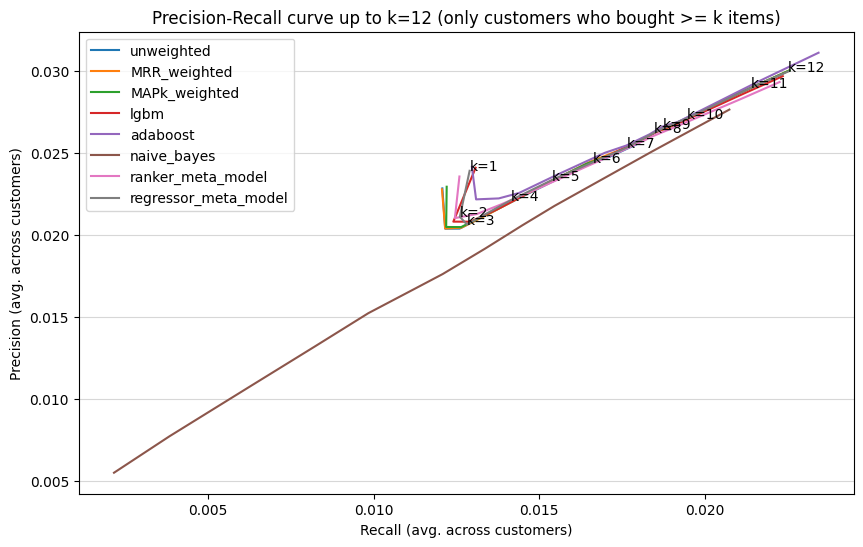

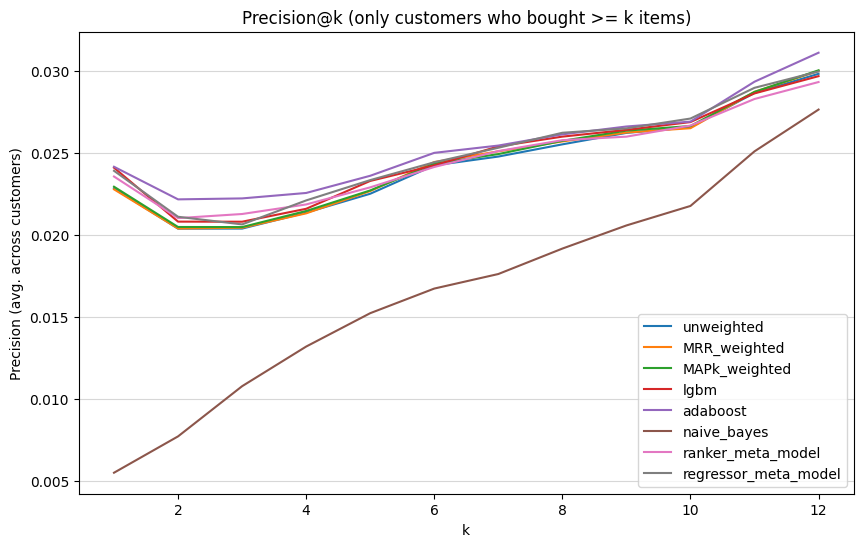

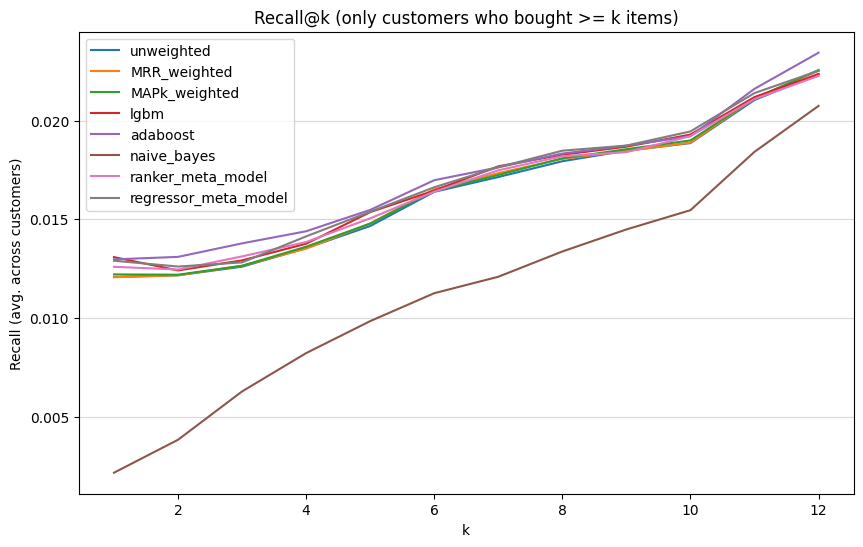

({'unweighted': [0.0011472470444175572,
   0.0010353649470108894,
   0.0010340489252353869,
   0.0010491477442981841,
   0.001051505042995444,
   0.0010632909290870778,
   0.0010681564909135908,
   0.0010762769547290824,
   0.0010861066210504913,
   0.0010947488283903225,
   0.0011028280432373943],
  'MRR_weighted': [0.0011443315500225951,
   0.001037916004606481,
   0.001035081496166935,
   0.0010499272341190588,
   0.0010533717692677743,
   0.0010670118288086483,
   0.0010704761683290103,
   0.0010822968122704902,
   0.0010916963612185684,
   0.0010989325688154459,
   0.0011061457203811861],
  'MAPk_weighted': [0.0011523491596087407,
   0.0010455691773932564,
   0.001042289246198924,
   0.0010567452392406113,
   0.0010604011477329599,
   0.0010732483547703153,
   0.0010774852837775975,
   0.001088922494341644,
   0.0010998145790970194,
   0.0011066558901768522,
   0.0011132908008257359],
  'lgbm': [0.0012106590475079813,
   0.0011058834676890333,
   0.0011106211460808466,
   0.001127

In [27]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

### Retraining weighted rank aggregation stacker without Naive Bayes ranker

In [28]:
del stacker.rankers[1]
for key, weights in stacker.ranker_weights.items():
    del weights[1]
del stacker.use_groups[1]

In [29]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

computing validation predictions for each of the base rankers...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848005
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.145441
[LightGBM] [Debug] init for col-wise cost 0.088170 seconds, init for row-wise cost 0.403730 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.270726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 6432764, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.861097
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.149076
[LightGBM] [Debug] init for col-wise cost 0.084008 seco

IndexError: list index out of range

In [ ]:
test['regressor_meta_model'] = stacker.predict(test_X, weighting="metamodel")

/home/peter/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [ ]:
test['MRR_weighted'] = stacker.predict(test_X, weighting="MRR")

In [ ]:
test['MAPk_weighted'] = stacker.predict(test_X, weighting="MAPk")

In [ ]:
test['lgbm'] = lgbm_ranker.predict(test_X)

In [ ]:
test['adaboost'] = adaboost_ranker.predict(test_X)

In [ ]:
pred_cols = ['unweighted', 'MRR_weighted', 'MAPk_weighted', 'lgbm', 'adaboost', 'regressor_meta_model']

In [ ]:
stacker.ranker_weights

{'MRR': [0.9347483118683491, 0.9003159348981736],
 'MAPk': [0.8737509332620338, 0.8288666352635037],
 'Pk': [0.0, 0.0]}

Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011379344178290979
MAP@12 (only purchasing customers): 0.022631672019209747

MRR (all customers):                0.0021488717699303856
MRR (only purchasing customers):    0.04273757814723835



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.0011642323847449504
MAP@12 (only purchasing customers): 0.023154695976202865

MRR (all customers):                0.002209746020260751
MRR (only purchasing customers):    0.04394826836479974



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.001165257527106334
MAP@12 (only purchasing customers): 0.023175084396952164

MRR (all customers):                0.002210885503171106
MRR (only purchasing customers):    0.043970930833826596



Evaluation for lgbm
####################

MAP@12 (all customers):             0.001157985612232424
MAP@12 (only purchasing customers): 0.02303045779123624

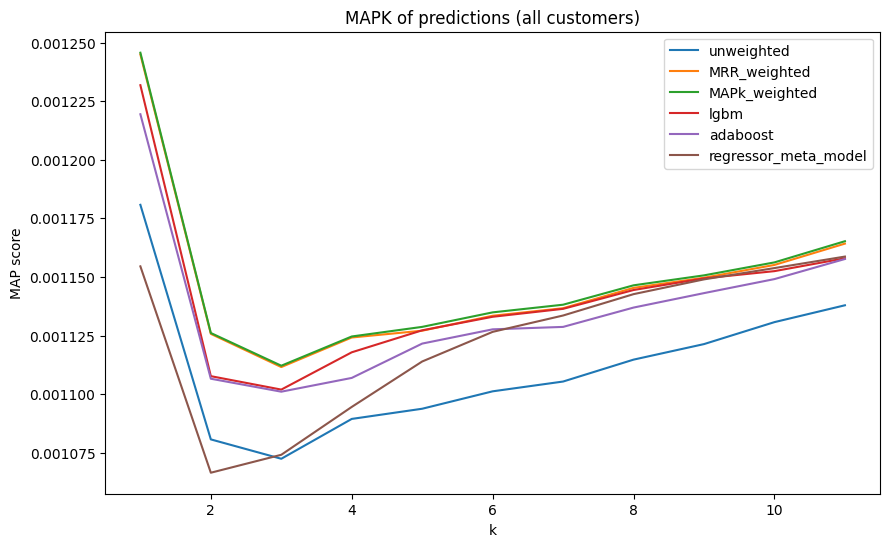

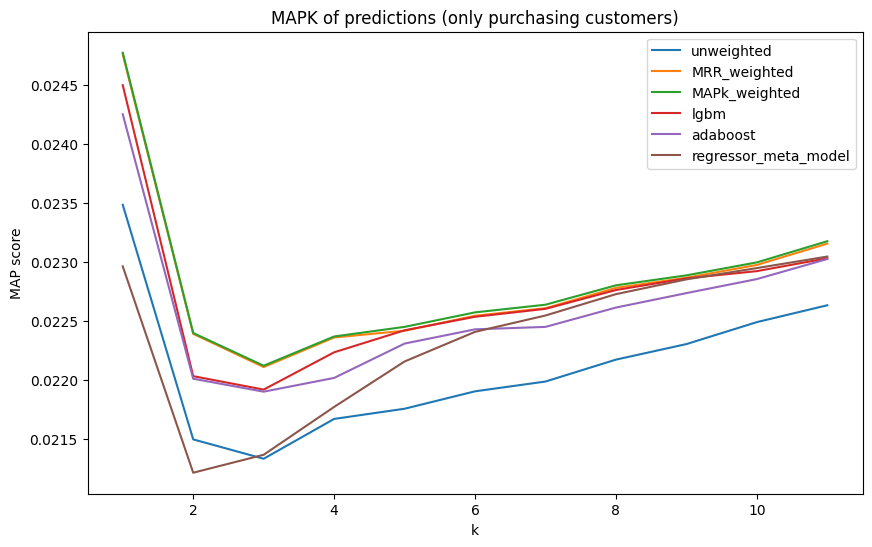

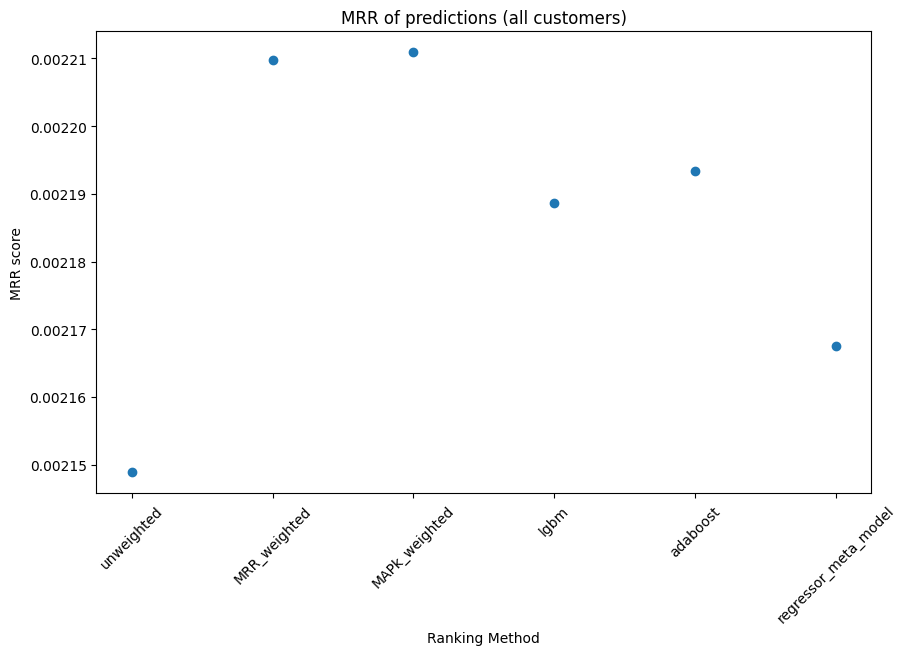

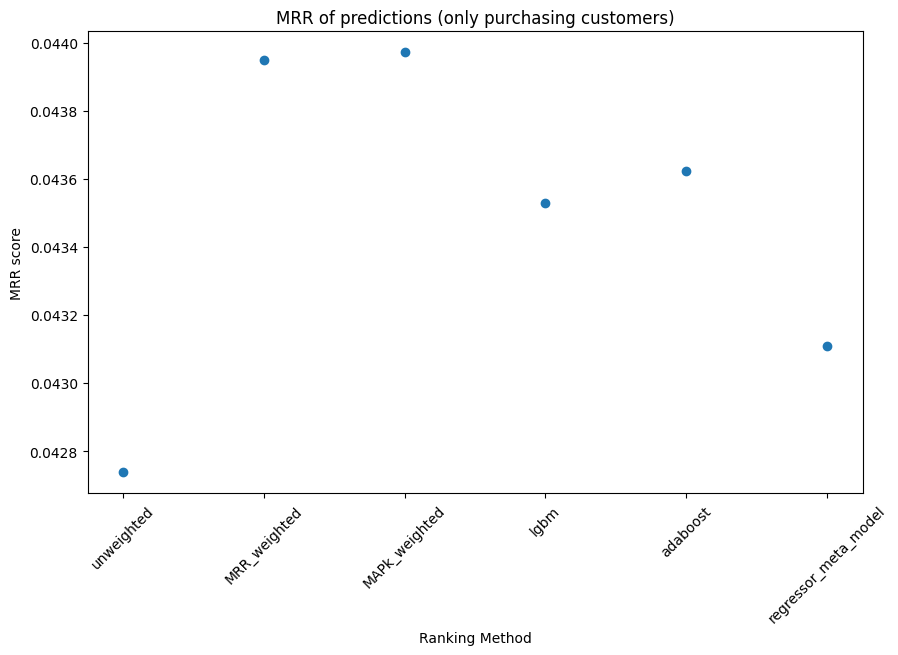

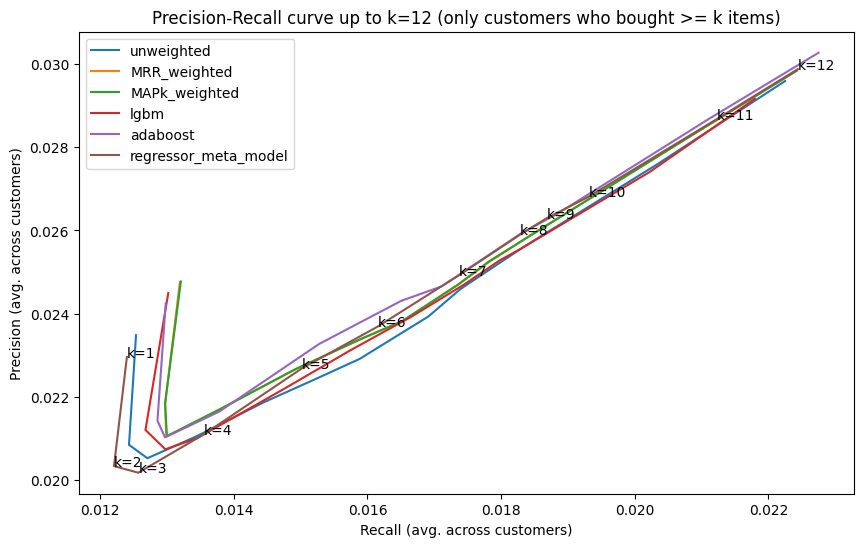

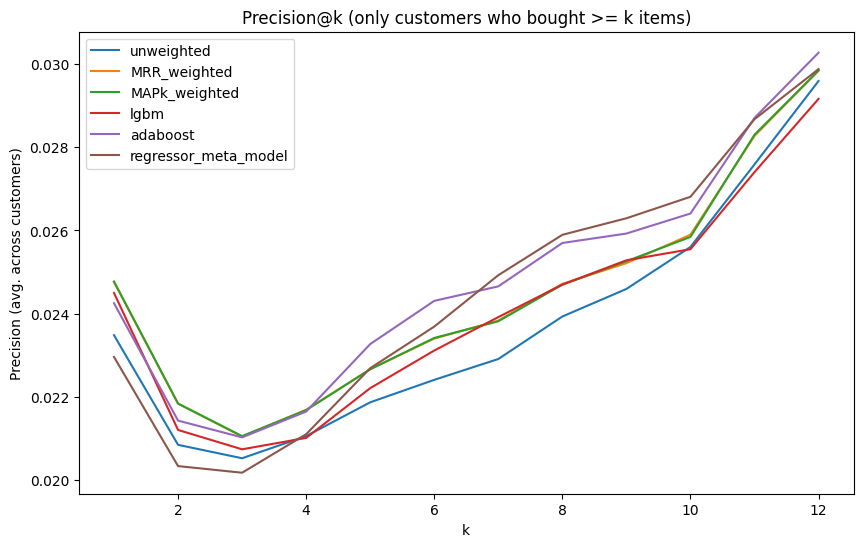

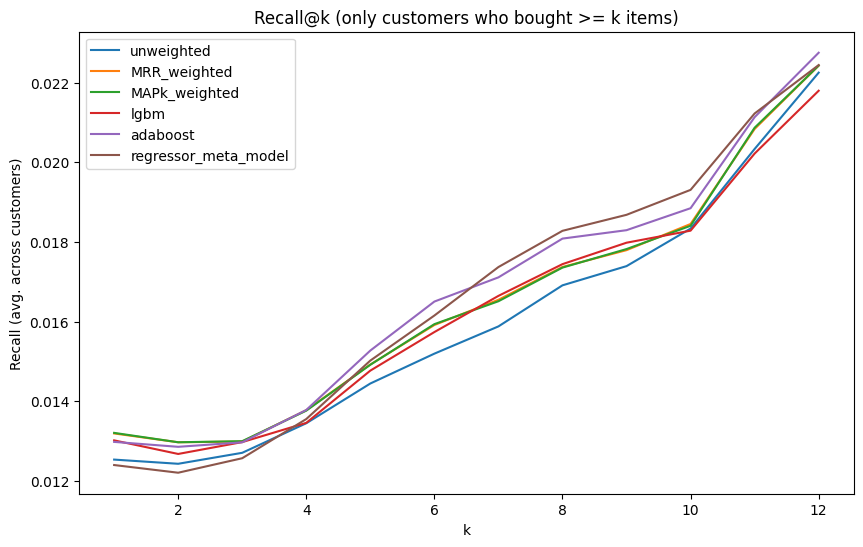

({'unweighted': [0.0011807752299596204,
   0.001080737328532486,
   0.0010724767610800936,
   0.0010894686268507307,
   0.0010938121061045596,
   0.0011012393280757245,
   0.0011054139061612094,
   0.001114755574139353,
   0.0011213822660098777,
   0.0011307518525647481,
   0.0011379344178290979],
  'MRR_weighted': [0.001244916106648785,
   0.001125745273254712,
   0.001111592977545834,
   0.0011241964168573885,
   0.001127091867228386,
   0.0011334703210769184,
   0.0011366844718421582,
   0.0011453628245590675,
   0.0011496786408423504,
   0.001155144643285349,
   0.0011642323847449504],
  'MAPk_weighted': [0.0012456449802475255,
   0.0011261097100540825,
   0.001112159879233743,
   0.0011246266547455341,
   0.0011287247465544526,
   0.0011349120735482054,
   0.0011381809311527152,
   0.0011464482233317632,
   0.001150696961069236,
   0.0011562294876898975,
   0.001165257527106334],
  'lgbm': [0.001231796381871456,
   0.0011077056516858846,
   0.0011019758953402304,
   0.001117879512

In [ ]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)